In [22]:
import numpy as np
from collections import defaultdict
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

from dwave.system import DWaveSampler

%matplotlib inline

## Graph Partitioning - a small example

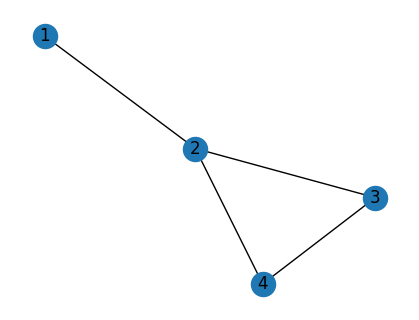

In [52]:
G = nx.Graph()
G.add_edge('1', '2')
G.add_edge('2', '3')
G.add_edge('3', '4')
G.add_edge('2', '4')
plt.figure(figsize=(4,3))
nx.draw(G, with_labels=True)

In [19]:
## the embedding to chimera 

## insert picture

In [24]:
"""
    Set up parameters
"""

## edges and nodes in the chimera label
nodes_list = [0,3,4,7]

N = 4
gamma = 2
h = 4
a = (1-N) * gamma

num_shots = 200

In [ ]:
## couplings dictionaries
Q = defaultdict(int)

Q.update({(0,0):1+a+h, 
         (3,3):2+a,
         (4,4):2+a+h,
         (7,7):2+a,
         (2,2):1+h,
         (5,5):h})

Q.update({(0,4):2*gamma-2,
         (3,4):2*gamma-2,
         (3,7):2*gamma-2,
         (2,7):2*gamma-2,
         (2,4):-2*h,
         (0,7):2*gamma,
         (3,5):2*gamma,
         (0,5):-2*h})

In [ ]:
## calling DW_2000Q_6 machine                       
solver = DWaveSampler(solver='DW_2000Q_6')

## use qubo to solve the problem Q
results = solver.sample_qubo(Q, num_reads=num_shots)

In [ ]:
print(results)

## Graph partitioning - random graph

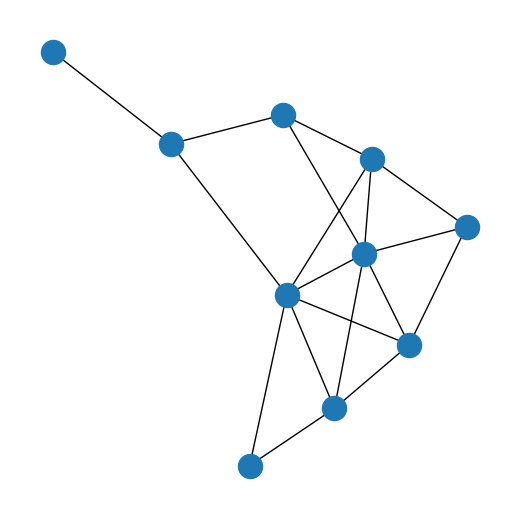

In [51]:
seed = 1574
N = 10
p = 0.39

ranG = nx.gnp_random_graph(N, p, seed)

plt.figure(figsize=(5,5))
nx.draw(ranG)

In [ ]:
## for random graph, the best way to embed it into D-Wave Chimera graph is using EmbeddingComposite
from dwave.system.composites import EmbeddingComposite

import math

In [ ]:
"""
    The code below is taken from https://github.com/dwave-examples/graph-partitioning/blob/master/graph_partitioning.py
"""

# ------- Set up our QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Fill in Q matrix
for u, v in ranG.edges:
    Q[(u,u)] += 1
    Q[(v,v)] += 1
    Q[(u,v)] += -2

for i in ranG.nodes:
    Q[(i,i)] += gamma*(1-len(ranG.nodes))

for i, j in combinations(ranG.nodes, 2):
	Q[(i,j)] += 2*gamma

# ------- Run our QUBO on the QPU -------

# Set chain strength
chain_strength = gamma*len(ranG.nodes)

# Run the QUBO on the solver from your config file
sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_6'))
response = sampler.sample_qubo(Q,
                               chain_strength=chain_strength,
                               num_reads=num_reads,
                               label='Example - Graph Partitioning')

# See if the best solution found is feasible, and if so print the number of cut edges.
sample = response.record.sample[0]

# In the case when n is odd, the set may have one more or one fewer nodes
if sum(sample) in [math.floor(len(G.nodes)/2), math.ceil(len(G.nodes)/2)]:
    num_cut_edges = 0
    for u, v in G.edges:
        num_cut_edges += sample[u] + sample[v] - 2*sample[u]*sample[v]
    print("Valid partition found with", num_cut_edges, "cut edges.")
else:
    print("Invalid partition.")

In [ ]:
"""
    Try it with pegasus and see what's the difference
"""